In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

In [5]:
from matplotlib import pyplot as plt

In [6]:
cuda_driver.init()

In [7]:
cuda_device = cuda_driver.Device(0)

In [8]:
print("Using {:s}".format(cuda_device.name() ))

Using Tesla P100-PCIE-12GB


# My first GPU program
I will not find $\pi$ today.

In [9]:
context = cuda_device.make_context()

In [10]:
free, total = cuda_driver.mem_get_info()
print("Memory is {:d} / {:d}".format(free, total))

Memory is 11980374016 / 12790923264


In [13]:
cuda_kernel = """
__global__ void addKernel(float* c, float* a, float* b, int cols, int rows) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    int k = i + j*cols;
    if (i <cols && j<rows){
        c[k] = a[k] + b[k];
    }
}
"""

In [14]:
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addKernel")

In [16]:
#?np.random.rand

In [17]:
nx = 50
ny = 25
a = np.random.rand(ny,nx).astype(np.float32)
b = np.random.rand(ny,nx).astype(np.float32)
c = np.empty_like(a)

In [18]:
a_gpu = GPUArray(a.shape, np.float32)
a_gpu.set(a)

In [19]:
b_gpu = GPUArray(b.shape, np.float32)
b_gpu.set(b)

In [20]:
c_gpu = GPUArray(c.shape, np.float32)

// er int-divisjon

In [30]:
block = (8,4,1)
domain = (nx, ny, 1)
grid = ((nx+7)//8, ((ny+3)//4), 1)

print(domain)
print(block)
print(grid)

(50, 25, 1)
(8, 4, 1)
(7, 7, 1)


In [32]:
kernel(c_gpu, a_gpu, b_gpu, np.int32(nx), np.int32(ny), block=block, grid=grid)

TODO: gjør om block og grid til matrise i stedet for array

In [33]:
#kernel(c_gpu, a_gpu, b_gpu, block=(n, 1, 1), grid=(1,1,1))

In [34]:
c_gpu.get(c)

array([[0.87747586, 0.93000567, 0.70452607, ..., 1.5158105 , 1.0512819 ,
        1.2757194 ],
       [1.0321975 , 1.4312348 , 0.34052086, ..., 0.95820266, 0.4029591 ,
        0.9685693 ],
       [0.91506505, 0.24454676, 0.7045081 , ..., 1.0405135 , 1.0588319 ,
        0.8032522 ],
       ...,
       [1.2505758 , 1.2784988 , 0.35249567, ..., 1.559103  , 0.819551  ,
        1.0523794 ],
       [0.55382204, 0.27560672, 0.95499325, ..., 1.1051366 , 0.5642036 ,
        0.7426703 ],
       [1.1162007 , 1.2920622 , 1.5642563 , ..., 0.9481404 , 1.3351811 ,
        0.7071316 ]], dtype=float32)

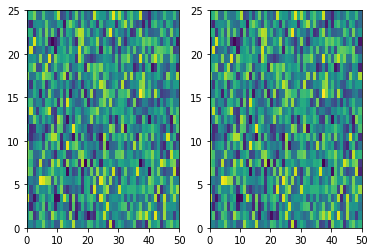

In [36]:
plt.subplot(1,2,1)
plt.pcolor(c)
plt.subplot(1,2,2)
plt.pcolor(a+b)
